# Numerical Stability and Initialization

So far we covered the tools needed to implement multilayer perceptrons, how to solve regression and classification problems, and how to control capacity. However, we took initialization of the parameters for granted, or rather simply assumed that they would not be particularly relevant. In the following we will look at them in more detail and discuss some useful heuristics.

Secondly, we were not particularly concerned with the choice of activation. Indeed, for shallow networks this is not very relevant. For deep networks, however, design choices of nonlinearity and initialization play a crucial role in making the optimization algorithm converge relatively rapidly. Failure to be mindful of these issues can lead to either exploding or vanishing gradients.


## Vanishing and Exploding Gradients

Consider a deep network with $d$ layers, input $\mathbf{x}$ and output $\mathbf{o}$. Each layer satisfies:

$$\mathbf{h}^{t+1} = f_t (\mathbf{h}^t) \text{ and thus } \mathbf{o} = f_d \circ \ldots \circ f_1(\mathbf{x})$$

If all activations and inputs are vectors, we can write the gradient of $\mathbf{o}$ with respect to any set of parameters $\mathbf{W}_t$ associated with the function $f_t$ at layer $t$ simply as

$$\partial_{\mathbf{W}_t} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{d-1}} \mathbf{h}^d}_{:= \mathbf{M}_d} \cdot \ldots \cdot \underbrace{\partial_{\mathbf{h}^{t}} \mathbf{h}^{t+1}}_{:= \mathbf{M}_t} \underbrace{\partial_{\mathbf{W}_t} \mathbf{h}^t}_{:= \mathbf{v}_t}.$$

In other words, it is the product of $d-t$ matrices $\mathbf{M}_d \cdot \ldots \cdot \mathbf{M}_t$ and the gradient vector $\mathbf{v}_t$. What happens is quite similar to the situation when we experienced numerical underflow when multiplying too many probabilities. At the time we were able to mitigate the problem by switching from into log-space, i.e. by shifting the problem from the mantissa to the exponent of the numerical representation. Unfortunately the problem outlined in the equation above is much more serious: initially the matrices $M_t$ may well have a wide variety of eigenvalues. They might be small, they might be large, and in particular, their product might well be *very large* or *very small*. This is not (only) a problem of numerical representation but it means that the optimization algorithm is bound to fail. It either receives gradients with excessively large or excessively small steps. In the former case, the parameters explode and in the latter case we end up with vanishing gradients and no meaningful progress.

### Exploding Gradients

To illustrate this a bit better, we draw 100 Gaussian random matrices and multiply them with some initial matrix. For the scaling that we picked, the matrix product explodes. If this were to happen to us with a deep network, we would have no meaningful chance of making the algorithm converge.

In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import nd, autograd
from matplotlib import pyplot as plt

M = nd.random.normal(shape=(4,4))
print('A single matrix', M)
for i in range(100):
    M = nd.dot(M, nd.random.normal(shape=(4,4)))

print('After multiplying 100 matrices', M)

A single matrix 
[[ 2.2122064   0.7740038   1.0434405   1.1839255 ]
 [ 1.8917114  -1.2347414  -1.771029   -0.45138445]
 [ 0.57938355 -1.856082   -1.9768796  -0.20801921]
 [ 0.2444218  -0.03716067 -0.48774993 -0.02261727]]
<NDArray 4x4 @cpu(0)>
After multiplying 100 matrices 
[[ 3.1575275e+20 -5.0052276e+19  2.0565092e+21 -2.3741922e+20]
 [-4.6332600e+20  7.3445046e+19 -3.0176513e+21  3.4838066e+20]
 [-5.8487235e+20  9.2711797e+19 -3.8092853e+21  4.3977330e+20]
 [-6.2947415e+19  9.9783660e+18 -4.0997977e+20  4.7331174e+19]]
<NDArray 4x4 @cpu(0)>


### Vanishing Gradients

The converse problem of vanishing gradients is just as bad. One of the major culprits in this context are the activation functions $\sigma$ that are interleaved with the linear operations in each layer. Historically, a popular activation used to be the sigmoid function $(1 + \exp(-x))$ that was introduced in the section discussing [Multilayer Perceptrons](../chapter_deep-learning-basics/mlp.md). Let us briefly review the function to see why picking it as nonlinear activation function might be problematic.

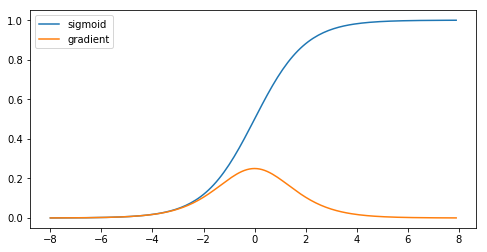

In [2]:
x = nd.arange(-8.0, 8.0, 0.1)
x.attach_grad()
with autograd.record():
    y = x.sigmoid()
y.backward()

plt.figure(figsize=(8, 4))
plt.plot(x.asnumpy(), y.asnumpy())
plt.plot(x.asnumpy(), x.grad.asnumpy())
plt.legend(['sigmoid', 'gradient'])
plt.show()

As we can see, the gradient of the sigmoid vanishes for very large or very small arguments. Due to the chain rule, this means that unless we are in the Goldilocks zone where the activations are in the range of, say $[-4, 4]$, the gradients of the overall product may vanish. When we have many layers this is likely to happen for *some* layer. Before ReLu $\max(0,x)$ was proposed, this problem used to be the bane of deep network training. As a consequence ReLu has become the default choice when designing activation functions in deep networks.

### Symmetry

A last problem in deep network design is the symmetry inherent in their parametrization. Assume that we have a deep network with one hidden layer with two units, say $h_1$ and $h_2$. In this case, we could flip the weights $\mathbf{W}_1$ of the first layer and likewise the outputs of the second layer and we would obtain the same function. More generally, we have permutation symmetry between the hidden units of each layer. This is more than just a theoretical nuisance. Assume that we initialize the parameters of some layer as $\mathbf{W}_l = 0$ or even just assume that all entries of $\mathbf{W}_l$ are identical. In this case the gradients for all dimensions are identical and we will never be able to use the expressive power inherent in a given layer. In fact, the hidden layer behaves as if it had only a single unit.


## Parameter Initialization

One way of addressing, or at least mitigating the issues raised above is through careful initialization of the weight vectors. This way we can ensure that at least initially the gradients do not vanish and that they are within a reasonable scale where the network weights do not diverge. Additional care during optimization and suitable regularization ensures that things never get too bad. Let's get started.

### Default Initialization

In the previous sections, e.g. in [“Concise Implementation of Linear Regression”](linear-regression-gluon.md), we used `net.initialize(init.Normal(sigma=0.01))` as a way to pick normally distributed random numbers as initial values for the weights. If the initialization method is not specified, such as `net.initialize()`, MXNet will use the default random initialization method: each element of the weight parameter is randomly sampled with an uniform distribution $U[-0.07, 0.07]$ and the bias parameters are all set to $0$. Both choices tend to work quite well in practice for moderate problem sizes.

### Xavier Initialization

Let's look at the scale distribution of the activations of the hidden units $h_{i}$ for some layer. They are given by

$$h_{i} = \sum_{j=1}^{n_\mathrm{in}} W_{ij} x_j$$

The weights $W_{ij}$ are all drawn independently from the same distribution. Let's furthermore assume that this distribution has zero mean and variance $\sigma^2$ (this doesn't mean that the distribution has to be Gaussian, just that mean and variance need to exist). We don't really have much control over the inputs into the layer $x_j$ but let's proceed with the somewhat unrealistic assumption that they also have zero mean and variance $\gamma^2$ and that they're independent of $\mathbf{W}$. In this case we can compute mean and variance of $h_i$ as follows:

$$
\begin{aligned}
    \mathbf{E}[h_i] & = \sum_{j=1}^{n_\mathrm{in}} \mathbf{E}[W_{ij} x_j] = 0 \\
    \mathbf{E}[h_i^2] & = \sum_{j=1}^{n_\mathrm{in}} \mathbf{E}[W^2_{ij} x^2_j] \\
        & = \sum_{j=1}^{n_\mathrm{in}} \mathbf{E}[W^2_{ij}] \mathbf{E}[x^2_j] \\
        & = n_\mathrm{in} \sigma^2 \gamma^2
\end{aligned}
$$

One way to keep the variance fixed is to set $n_\mathrm{in} \sigma^2 = 1$. Now consider backpropagation. There we face a similar problem, albeit with gradients being propagated from the top layers. That is, instead of $\mathbf{W} \mathbf{w}$ we need to deal with $\mathbf{W}^\top \mathbf{g}$, where $\mathbf{g}$ is the incoming gradient from the layer above. Using the same reasoning as for forward propagation we see that the gradients' variance can blow up unless $n_\mathrm{out} \sigma^2 = 1$. This leaves us in a dilemma: we cannot possibly satisfy both conditions simultaneously. Instead, we simply try to satisfy

$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}
\end{aligned}
$$

This is the reasoning underlying the eponymous Xavier initialization, proposed by [Xavier Glorot and Yoshua Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) in 2010. It works well enough in practice. For Gaussian random variables the Xavier initialization picks a normal distribution with zero mean and variance $\sigma^2 = 2/(n_\mathrm{in} + n_\mathrm{out})$.
For uniformly distributed random variables $U[-a, a]$ note that their variance is given by $a^2/3$. Plugging $a^2/3$ into the condition on $\sigma^2$ yields that we should initialize uniformly with
$U\left[-\sqrt{6/(n_\mathrm{in} + n_\mathrm{out})}, \sqrt{6/(n_\mathrm{in} + n_\mathrm{out})}\right]$.

### Beyond

The reasoning above barely scratches the surface. In fact, MXNet has an entire `mxnet.initializer` module with over a dozen different heuristics. They can be used, e.g. when parameters are tied (i.e. when parameters of in different parts the network are shared), for superresolution, sequence models, and related problems. We recommend the reader to review what is offered as part of this module.


## Summary

* Vanishing and exploding gradients are common issues in very deep networks, unless great care is taking to ensure that gradients and parameters remain well controlled.
* Initialization heuristics are needed to ensure that at least the initial gradients are neither too large nor too small.
* The ReLu addresses one of the vanishing gradient problems, namely that gradients vanish for very large inputs. This can accelerate convergence significantly.
* Random initialization is key to ensure that symmetry is broken before optimization.

## Exercises

1. Can you design other cases of symmetry breaking besides the permutation symmetry?
1. Can we initialize all weight parameters in linear regression or in softmax regression to the same value?
1. Look up analytic bounds on the eigenvalues of the product of two matrices. What does this tell you about ensuring that gradients are well conditioned?
1. If we know that some terms diverge, can we fix this after the fact? Look at the paper on LARS by [You, Gitman and Ginsburg, 2017](https://arxiv.org/pdf/1708.03888.pdf) for inspiration.

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2345)

![](../img/qr_numerical-stability-and-init.svg)